In [ ]:
#connecting to drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()

#uploading the original kaggle.json
!ls -lha kaggle.json


Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 70 Feb  4 18:53 kaggle.json


In [ ]:
# kaggle directory
!mkdir -p ~/.kaggle

# Copying to directory
!cp kaggle.json ~/.kaggle/

# Permissions
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
#Statement to download the dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/drive/MyDrive/GSMP2 --unzip

 99% 147M/149M [00:04<00:00, 43.3MB/s]
100% 149M/149M [00:04<00:00, 37.4MB/s]


In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import imutils

def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# thresholding the image, then performing a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# finding contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# finding the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

if __name__ == "__main__":
	training = "/content/drive/MyDrive/GSMP2/Training"
	testing = "/content/drive/MyDrive/GSMP2/Testing"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256

	for dir in training_dir:
		save_path = '/content/drive/MyDrive/GSMP2/cleaned/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

	for dir in testing_dir:
		save_path = '/content/drive/MyDrive/GSMP2/cleaned/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

Importing Libraries


In [ ]:

from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime

import cv2
import os
import io

In [ ]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/GSMP2/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))

    testPath = os.path.join('/content/drive/MyDrive/GSMP2/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)


100%|██████████| 300/300 [00:06<00:00, 45.95it/s] 


(5712, 200, 200, 3)
(1311, 200, 200, 3)


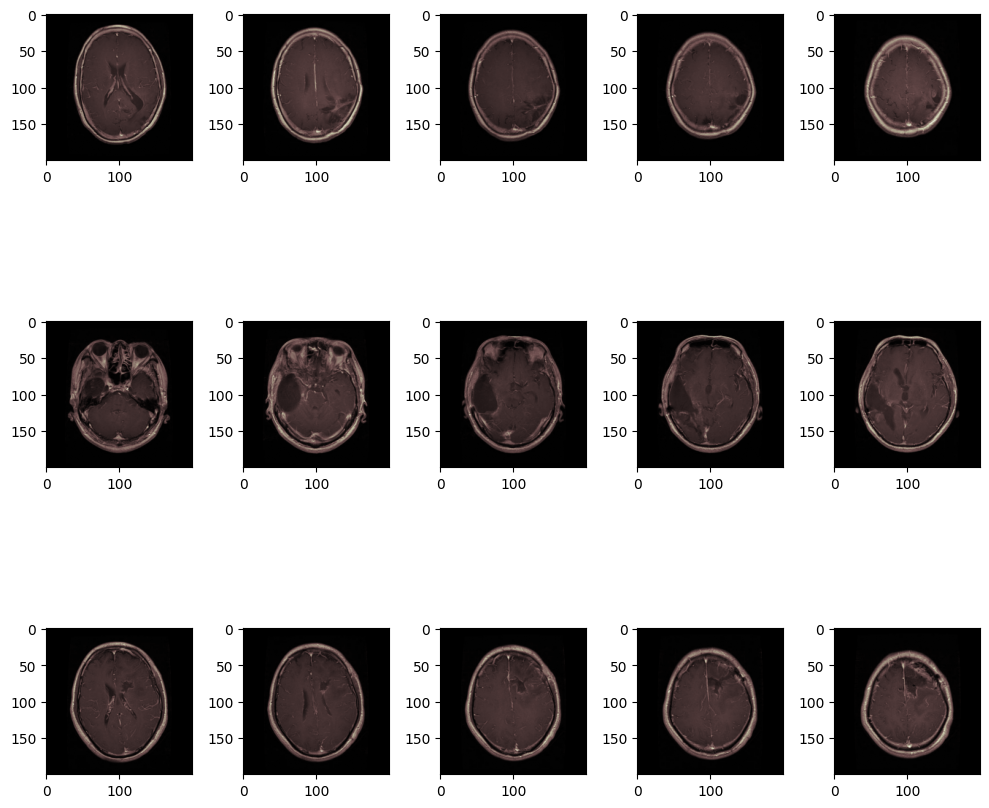

In [ ]:

images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [ ]:
x_train, y_train = shuffle(x_train,y_train, random_state=42)

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1143, 200, 200, 3)


In [ ]:
import numpy as np

# Specify the path to save the dataset
save_path = '/content/drive/MyDrive/GSMP2/processed_data.npz'

# Saving the datasets
np.savez_compressed(save_path, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, x_val=x_val, y_val=y_val)


In [ ]:
#Load to start the work.
# Load the datasets
import numpy as np

save_path = '/content/drive/MyDrive/GSMP2/processed_data.npz'
data = np.load(save_path)

# Extracting the datasets
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']
x_val = data['x_val']
y_val = data['y_val']

Convolutional Autoencoder


In [ ]:
noise_factor = 0.5
# noise addition
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape)
# Clip the values of the noisy training data and testing data to the range of 0 to 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

In [ ]:
# Reshape the input images to (200, 200, 3)
x_train = np.reshape(x_train, (len(x_train), 200, 200, 3))
x_val = np.reshape(x_val, (len(x_val), 200, 200, 3))
x_train_noisy = np.reshape(x_train_noisy, (len(x_train_noisy), 200, 200, 3))
x_val_noisy = np.reshape(x_val_noisy, (len(x_val_noisy), 200, 200, 3))


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
input_shape = (200, 200, 3)

# Model definition

inputs = Input(shape=input_shape)
# Encoder
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Dropout(0.2)(encoded)  # Added dropout for regularization
# Decoder
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

# Instantiate the Autoencoder Model
autoencoder1 = Model(inputs, decoded)
# Compile the model
autoencoder1.compile(optimizer='adam', loss='binary_crossentropy')

# Callbacks for early stopping and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
]



In [ ]:
# Train the autoencoder
batch_size = 128
epochs = 100

history = autoencoder1.fit(
    x_train_noisy, x_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val_noisy, x_val),
    callbacks=callbacks
)


Epoch 1/100
36/36 [==============================] - 32s 600ms/step - loss: 0.5057 - val_loss: 0.4281 - lr: 0.0010
Epoch 2/100
36/36 [==============================] - 12s 336ms/step - loss: 0.3869 - val_loss: 0.3689 - lr: 0.0010
Epoch 3/100
36/36 [==============================] - 12s 336ms/step - loss: 0.3645 - val_loss: 0.3624 - lr: 0.0010
Epoch 4/100
36/36 [==============================] - 12s 337ms/step - loss: 0.3596 - val_loss: 0.3591 - lr: 0.0010
Epoch 5/100
36/36 [==============================] - 12s 336ms/step - loss: 0.3576 - val_loss: 0.3578 - lr: 0.0010
Epoch 6/100
36/36 [==============================] - 12s 338ms/step - loss: 0.3565 - val_loss: 0.3570 - lr: 0.0010
Epoch 7/100
36/36 [==============================] - 12s 337ms/step - loss: 0.3557 - val_loss: 0.3565 - lr: 0.0010
Epoch 8/100
36/36 [==============================] - 12s 340ms/step - loss: 0.3552 - val_loss: 0.3560 - lr: 0.0010
Epoch 9/100
36/36 [==============================] - 12s 342ms/step - loss: 0.35

In [ ]:
# Report the loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
#printing the training and the validation loss
print("Train Loss:", train_loss[-1])
print("Validation Loss:", val_loss[-1])

Train Loss: 0.3486550450325012
Validation Loss: 0.3506101369857788


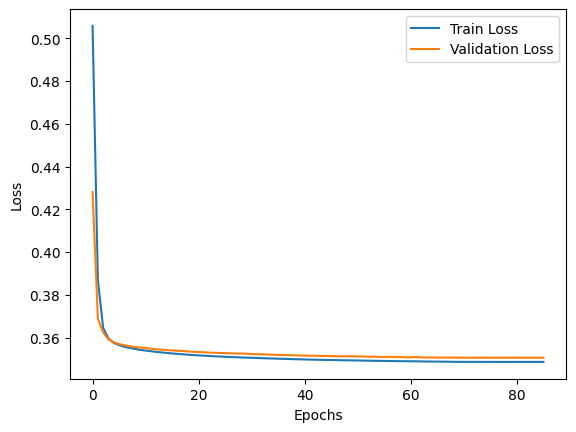

In [ ]:
actual_epochs = len(train_loss)
# Plot the loss curve
import matplotlib.pyplot as plt

plt.plot(range(actual_epochs), train_loss, label='Train Loss')
plt.plot(range(actual_epochs), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

# Add noise to the test images
noise_factor = 0.5
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
reconstructed_images = autoencoder1.predict(x_test_noisy)


41/41 [==============================] - 2s 32ms/step


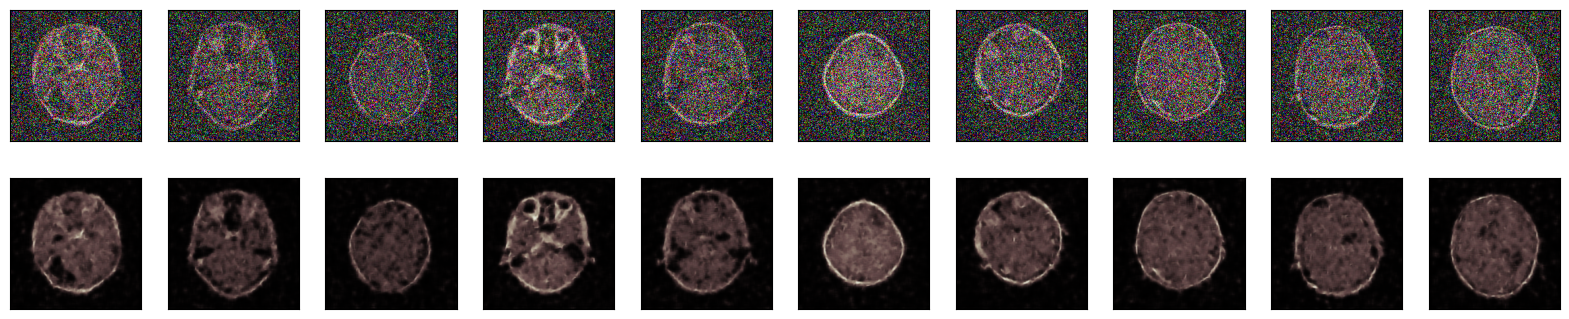

In [ ]:
# Display some predictions
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Noisy images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Denoising Autoencoder


In [ ]:
# Flatten the input images
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val_flat = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_train_noisy_flat = x_train_noisy.reshape((len(x_train_noisy), np.prod(x_train_noisy.shape[1:])))
x_val_noisy_flat = x_val_noisy.reshape((len(x_val_noisy), np.prod(x_val_noisy.shape[1:])))

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Model definition
input_dim = 120000
encoding_dim = 32

#Adding only dense layers this time around for comparison of results wuth the previous case
inputs = tf.keras.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(inputs)
decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoded)

#Instantiate
autoencoder1 = tf.keras.Model(inputs, decoded)
autoencoder1.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# Train the denoising autoencoder
batch_size = 128
epochs = 100

history1 = autoencoder1.fit(x_train_noisy_flat, x_train_flat,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_val_noisy_flat, x_val_flat))

Epoch 1/100
36/36 [==============================] - 7s 149ms/step - loss: 0.4660 - val_loss: 0.4259
Epoch 2/100
36/36 [==============================] - 2s 58ms/step - loss: 0.4106 - val_loss: 0.4105
Epoch 3/100
36/36 [==============================] - 2s 59ms/step - loss: 0.3984 - val_loss: 0.4052
Epoch 4/100
36/36 [==============================] - 2s 56ms/step - loss: 0.3938 - val_loss: 0.4026
Epoch 5/100
36/36 [==============================] - 2s 56ms/step - loss: 0.3913 - val_loss: 0.4014
Epoch 6/100
36/36 [==============================] - 2s 57ms/step - loss: 0.3899 - val_loss: 0.4010
Epoch 7/100
36/36 [==============================] - 2s 58ms/step - loss: 0.3888 - val_loss: 0.4010
Epoch 8/100
36/36 [==============================] - 2s 57ms/step - loss: 0.3879 - val_loss: 0.3997
Epoch 9/100
36/36 [==============================] - 2s 58ms/step - loss: 0.3872 - val_loss: 0.3987
Epoch 10/100
36/36 [==============================] - 2s 58ms/step - loss: 0.3857 - val_loss: 0.397

In [ ]:
# Report the loss
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']


#Printing the loss
print("Train Loss:", train_loss[-1])
print("Validation Loss:", val_loss[-1])

Train Loss: 0.3777529001235962
Validation Loss: 0.3955560326576233


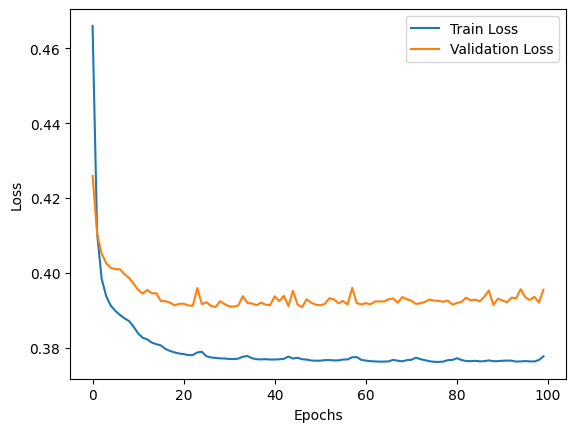

In [ ]:
actual_epochs = len(train_loss)
# Plot the loss curve
import matplotlib.pyplot as plt
# Plot the loss curve
plt.plot(range(epochs), train_loss, label='Train Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Flatten the images
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_test_noisy_flat = x_test_noisy.reshape((len(x_test), np.prod(x_test.shape[1:])))

41/41 [==============================] - 0s 7ms/step


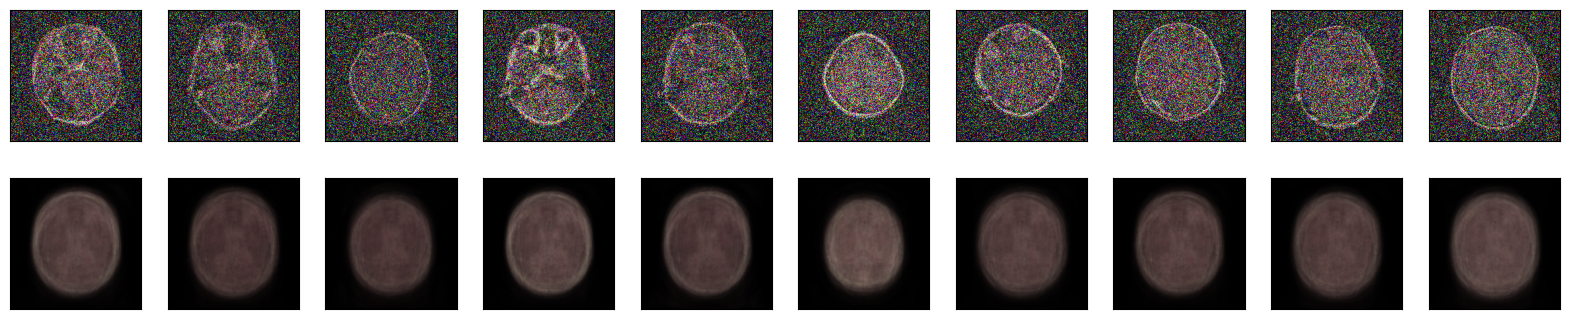

In [ ]:
# Reconstructed images
reconstructed_images1 = autoencoder1.predict(x_test_noisy_flat)

n=10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Noisy images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images1[i].reshape(200,200,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We are done with noise. We will now consider blurring the images in the next step

Deblurring Autoencoder

In [ ]:
# function to reduce image resolution while keeping the image size constant

def pixalate_image(image, scale_percent = 20):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

In [ ]:
# get low resolution images for the training set
train_x_px = []

for i in range(x_train.shape[0]):
  temp = pixalate_image(x_train[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(x_val.shape[0]):
  temp = pixalate_image(x_val[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

# get low resolution images for the test set
test_x_px = []

for i in range(x_test.shape[0]):
  temp = pixalate_image(x_test[i,:,:,:])
  test_x_px.append(temp)

test_x_px = np.array(test_x_px)

In [ ]:
Input_img = Input(shape=(200, 200, 3))

# Model definition

#encoding architecture
x1 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = tf.keras.layers.MaxPool2D( (2, 2))(x2)
encoded = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = tf.keras.layers.UpSampling2D((2, 2))(x3)
x2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 256)     7168      
                                                                 
 conv2d_4 (Conv2D)           (None, 200, 200, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 100, 100, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      73792     
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 64)      36928     
                                                           

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, mode='auto')

a_e = autoencoder.fit(train_x_px, x_train,
            epochs=5,
            batch_size=128,
            shuffle=True,
            validation_data=(val_x_px, x_val),
            callbacks=[early_stopper],
            verbose = 0)

In [ ]:
# Report the loss
train_loss = a_e.history['loss']
val_loss = a_e.history['val_loss']

print("Train Loss:", train_loss[-1])
print("Validation Loss:", val_loss[-1])

Train Loss: 0.0038542526308447123
Validation Loss: 0.0038935886695981026


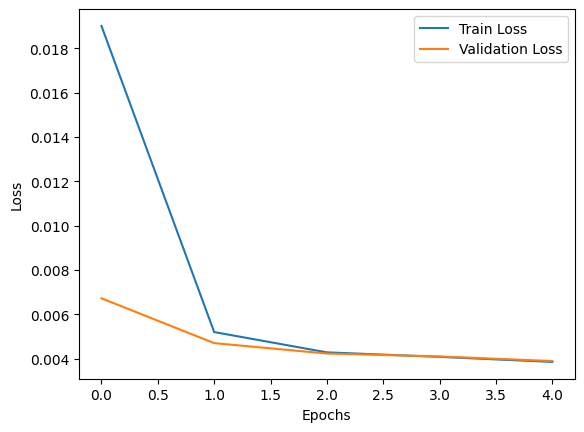

In [ ]:
import matplotlib.pyplot as plt
# Plot the loss curve
plt.plot(range(5), train_loss, label='Train Loss')
plt.plot(range(5), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = autoencoder.predict(test_x_px)

41/41 [==============================] - 8s 113ms/step


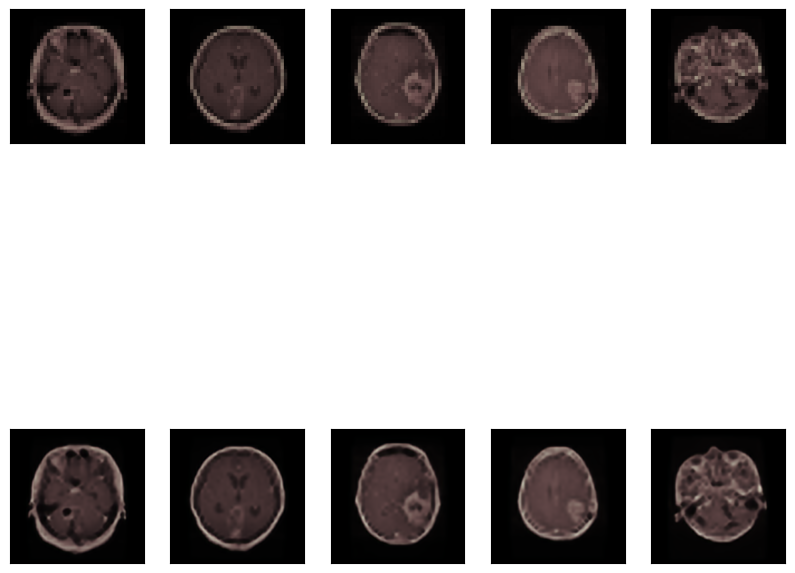

In [ ]:
n = 5
plt.figure(figsize= (10,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(test_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

Pretrained models Implementation (for comparison purpose)


This has been performed on data without any of our augmentation

In [ ]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)


datagen.fit(x_train)

In [ ]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model

In [ ]:
net = ResNet50(
    weights='imagenet',
     include_top=False,
     input_shape=(200,200,3))

In [ ]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
%load_ext tensorboard


class_names = list(labels)
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return figure

# Following function will make predictions from the model and log the confusion matrix as an image.
def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Run tensorBoard
%tensorboard --logdir logs

In [ ]:
#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)


Epoch 1/50
229/229 [==============================] - ETA: 0s - loss: 0.2857 - accuracy: 0.8949
Epoch 1: val_loss improved from inf to 2.55995, saving model to model-01-0.33-2.56.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 92s 274ms/step - loss: 0.2857 - accuracy: 0.8949 - val_loss: 2.5600 - val_accuracy: 0.3307 - lr: 1.0000e-04
Epoch 2/50
229/229 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9545
Epoch 2: val_loss improved from 2.55995 to 1.68915, saving model to model-02-0.41-1.69.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 60s 261ms/step - loss: 0.1363 - accuracy: 0.9545 - val_loss: 1.6891 - val_accuracy: 0.4147 - lr: 1.0000e-04
Epoch 3/50
229/229 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9683
Epoch 3: val_loss did not improve from 1.68915
229/229 [==============================] - 59s 256ms/step - loss: 0.0958 - accuracy: 0.9683 - val_loss: 1.6894 - val_accuracy: 0.3972 - lr: 1.0000e-04
Epoch 4/50
229/229 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9796
Epoch 4: val_loss improved from 1.68915 to 0.32481, saving model to model-04-0.88-0.32.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 60s 260ms/step - loss: 0.0616 - accuracy: 0.9796 - val_loss: 0.3248 - val_accuracy: 0.8836 - lr: 1.0000e-04
Epoch 5/50
229/229 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9821
Epoch 5: val_loss improved from 0.32481 to 0.25619, saving model to model-05-0.93-0.26.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 60s 261ms/step - loss: 0.0527 - accuracy: 0.9821 - val_loss: 0.2562 - val_accuracy: 0.9309 - lr: 1.0000e-04
Epoch 6/50
229/229 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9807
Epoch 6: val_loss improved from 0.25619 to 0.10447, saving model to model-06-0.96-0.10.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 60s 260ms/step - loss: 0.0637 - accuracy: 0.9807 - val_loss: 0.1045 - val_accuracy: 0.9598 - lr: 1.0000e-04
Epoch 7/50
229/229 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9899
Epoch 7: val_loss did not improve from 0.10447
229/229 [==============================] - 59s 257ms/step - loss: 0.0338 - accuracy: 0.9899 - val_loss: 0.1445 - val_accuracy: 0.9650 - lr: 1.0000e-04
Epoch 8/50
229/229 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9895
Epoch 8: val_loss improved from 0.10447 to 0.05291, saving model to model-08-0.99-0.05.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 60s 261ms/step - loss: 0.0308 - accuracy: 0.9895 - val_loss: 0.0529 - val_accuracy: 0.9851 - lr: 1.0000e-04
Epoch 9/50
229/229 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9891
Epoch 9: val_loss did not improve from 0.05291
229/229 [==============================] - 59s 258ms/step - loss: 0.0348 - accuracy: 0.9891 - val_loss: 0.1161 - val_accuracy: 0.9738 - lr: 1.0000e-04
Epoch 10/50
229/229 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9917
Epoch 10: val_loss did not improve from 0.05291
229/229 [==============================] - 59s 257ms/step - loss: 0.0280 - accuracy: 0.9917 - val_loss: 0.0535 - val_accuracy: 0.9816 - lr: 1.0000e-04
Epoch 11/50
229/229 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9891
Epoch 11: val_loss did not improve from 0.05291
229/229 [==============================] - 59s 257ms/step - loss: 0.0377 - accuracy: 0.9891 - val_loss: 0.0861 - v

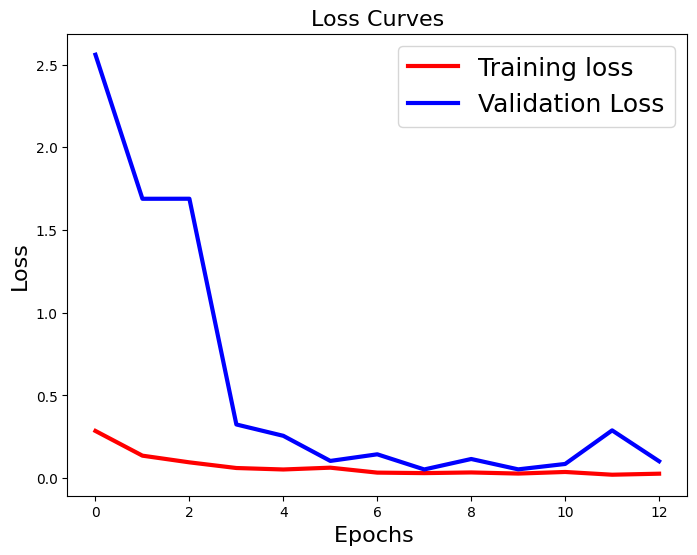

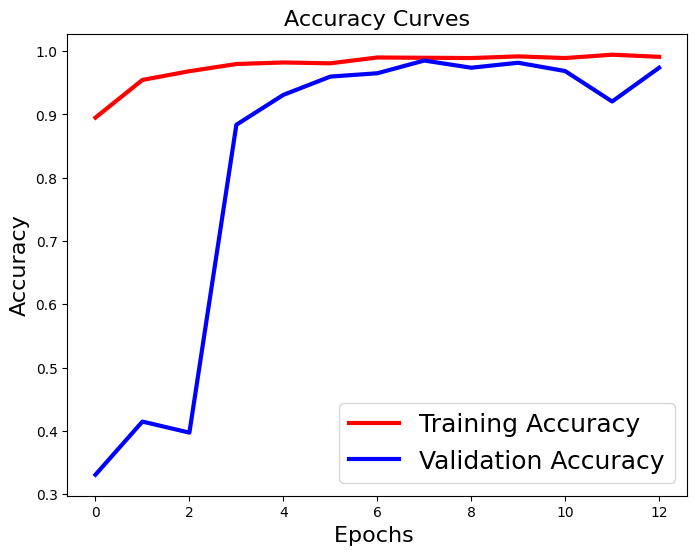

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

In [ ]:
loss,acc = model.evaluate(x_test,y_test)


41/41 [==============================] - 3s 80ms/step - loss: 0.0825 - accuracy: 0.9786


Done with Resnet

In [ ]:
from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam

# Load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(200, 200, 3))

headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(4, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

#Freezing layers
for layer in baseModel.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [ ]:
#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)

Epoch 1/50
229/229 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.7905
Epoch 1: val_loss improved from inf to 0.54713, saving model to model-01-0.86-0.55.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 214ms/step - loss: 0.6084 - accuracy: 0.7905 - val_loss: 0.5471 - val_accuracy: 0.8556 - lr: 1.0000e-04
Epoch 2/50
229/229 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.7936
Epoch 2: val_loss improved from 0.54713 to 0.54462, saving model to model-02-0.85-0.54.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 211ms/step - loss: 0.5997 - accuracy: 0.7936 - val_loss: 0.5446 - val_accuracy: 0.8513 - lr: 1.0000e-04
Epoch 3/50
229/229 [==============================] - ETA: 0s - loss: 0.6033 - accuracy: 0.7960
Epoch 3: val_loss improved from 0.54462 to 0.54186, saving model to model-03-0.85-0.54.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 211ms/step - loss: 0.6033 - accuracy: 0.7960 - val_loss: 0.5419 - val_accuracy: 0.8548 - lr: 1.0000e-04
Epoch 4/50
229/229 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.8028
Epoch 4: val_loss improved from 0.54186 to 0.53961, saving model to model-04-0.85-0.54.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 211ms/step - loss: 0.5985 - accuracy: 0.8028 - val_loss: 0.5396 - val_accuracy: 0.8521 - lr: 1.0000e-04
Epoch 5/50
229/229 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.7945
Epoch 5: val_loss improved from 0.53961 to 0.53660, saving model to model-05-0.85-0.54.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 211ms/step - loss: 0.5975 - accuracy: 0.7945 - val_loss: 0.5366 - val_accuracy: 0.8548 - lr: 1.0000e-04
Epoch 6/50
229/229 [==============================] - ETA: 0s - loss: 0.5880 - accuracy: 0.8039
Epoch 6: val_loss improved from 0.53660 to 0.53543, saving model to model-06-0.86-0.54.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 210ms/step - loss: 0.5880 - accuracy: 0.8039 - val_loss: 0.5354 - val_accuracy: 0.8583 - lr: 1.0000e-04
Epoch 7/50
229/229 [==============================] - ETA: 0s - loss: 0.5986 - accuracy: 0.7888
Epoch 7: val_loss improved from 0.53543 to 0.53125, saving model to model-07-0.86-0.53.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 213ms/step - loss: 0.5986 - accuracy: 0.7888 - val_loss: 0.5313 - val_accuracy: 0.8583 - lr: 1.0000e-04
Epoch 8/50
229/229 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.7910
Epoch 8: val_loss improved from 0.53125 to 0.52864, saving model to model-08-0.86-0.53.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 211ms/step - loss: 0.5954 - accuracy: 0.7910 - val_loss: 0.5286 - val_accuracy: 0.8574 - lr: 1.0000e-04
Epoch 9/50
229/229 [==============================] - ETA: 0s - loss: 0.5962 - accuracy: 0.7853
Epoch 9: val_loss improved from 0.52864 to 0.52683, saving model to model-09-0.86-0.53.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 211ms/step - loss: 0.5962 - accuracy: 0.7853 - val_loss: 0.5268 - val_accuracy: 0.8583 - lr: 1.0000e-04
Epoch 10/50
229/229 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.7945
Epoch 10: val_loss did not improve from 0.52683
229/229 [==============================] - 48s 211ms/step - loss: 0.5862 - accuracy: 0.7945 - val_loss: 0.5272 - val_accuracy: 0.8626 - lr: 1.0000e-04
Epoch 11/50
229/229 [==============================] - ETA: 0s - loss: 0.5842 - accuracy: 0.7975
Epoch 11: val_loss improved from 0.52683 to 0.52360, saving model to model-11-0.86-0.52.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 212ms/step - loss: 0.5842 - accuracy: 0.7975 - val_loss: 0.5236 - val_accuracy: 0.8583 - lr: 1.0000e-04
Epoch 12/50
229/229 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.7949
Epoch 12: val_loss improved from 0.52360 to 0.52197, saving model to model-12-0.86-0.52.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 213ms/step - loss: 0.5868 - accuracy: 0.7949 - val_loss: 0.5220 - val_accuracy: 0.8583 - lr: 1.0000e-04
Epoch 13/50
229/229 [==============================] - ETA: 0s - loss: 0.5878 - accuracy: 0.7982
Epoch 13: val_loss improved from 0.52197 to 0.51895, saving model to model-13-0.86-0.52.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 211ms/step - loss: 0.5878 - accuracy: 0.7982 - val_loss: 0.5190 - val_accuracy: 0.8583 - lr: 1.0000e-04
Epoch 14/50
229/229 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.7965
Epoch 14: val_loss improved from 0.51895 to 0.51658, saving model to model-14-0.86-0.52.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 211ms/step - loss: 0.5868 - accuracy: 0.7965 - val_loss: 0.5166 - val_accuracy: 0.8591 - lr: 1.0000e-04
Epoch 15/50
229/229 [==============================] - ETA: 0s - loss: 0.5780 - accuracy: 0.8052
Epoch 15: val_loss improved from 0.51658 to 0.51506, saving model to model-15-0.86-0.52.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 210ms/step - loss: 0.5780 - accuracy: 0.8052 - val_loss: 0.5151 - val_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 16/50
229/229 [==============================] - ETA: 0s - loss: 0.5854 - accuracy: 0.8000
Epoch 16: val_loss improved from 0.51506 to 0.51309, saving model to model-16-0.86-0.51.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 213ms/step - loss: 0.5854 - accuracy: 0.8000 - val_loss: 0.5131 - val_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 17/50
229/229 [==============================] - ETA: 0s - loss: 0.5769 - accuracy: 0.8026
Epoch 17: val_loss improved from 0.51309 to 0.51212, saving model to model-17-0.86-0.51.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 209ms/step - loss: 0.5769 - accuracy: 0.8026 - val_loss: 0.5121 - val_accuracy: 0.8591 - lr: 1.0000e-04
Epoch 18/50
229/229 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.8087
Epoch 18: val_loss improved from 0.51212 to 0.51052, saving model to model-18-0.86-0.51.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 212ms/step - loss: 0.5727 - accuracy: 0.8087 - val_loss: 0.5105 - val_accuracy: 0.8626 - lr: 1.0000e-04
Epoch 19/50
229/229 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.8048
Epoch 19: val_loss improved from 0.51052 to 0.50809, saving model to model-19-0.86-0.51.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 212ms/step - loss: 0.5603 - accuracy: 0.8048 - val_loss: 0.5081 - val_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 20/50
229/229 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.8017
Epoch 20: val_loss improved from 0.50809 to 0.50643, saving model to model-20-0.86-0.51.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 212ms/step - loss: 0.5732 - accuracy: 0.8017 - val_loss: 0.5064 - val_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 21/50
229/229 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.8096
Epoch 21: val_loss improved from 0.50643 to 0.50424, saving model to model-21-0.86-0.50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 212ms/step - loss: 0.5635 - accuracy: 0.8096 - val_loss: 0.5042 - val_accuracy: 0.8618 - lr: 1.0000e-04
Epoch 22/50
229/229 [==============================] - ETA: 0s - loss: 0.5767 - accuracy: 0.7986
Epoch 22: val_loss improved from 0.50424 to 0.50310, saving model to model-22-0.86-0.50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 215ms/step - loss: 0.5767 - accuracy: 0.7986 - val_loss: 0.5031 - val_accuracy: 0.8609 - lr: 1.0000e-04
Epoch 23/50
229/229 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.8006
Epoch 23: val_loss improved from 0.50310 to 0.50106, saving model to model-23-0.86-0.50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 214ms/step - loss: 0.5696 - accuracy: 0.8006 - val_loss: 0.5011 - val_accuracy: 0.8626 - lr: 1.0000e-04
Epoch 24/50
229/229 [==============================] - ETA: 0s - loss: 0.5616 - accuracy: 0.8032
Epoch 24: val_loss improved from 0.50106 to 0.49883, saving model to model-24-0.86-0.50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 214ms/step - loss: 0.5616 - accuracy: 0.8032 - val_loss: 0.4988 - val_accuracy: 0.8644 - lr: 1.0000e-04
Epoch 25/50
229/229 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.8021
Epoch 25: val_loss did not improve from 0.49883
229/229 [==============================] - 49s 212ms/step - loss: 0.5663 - accuracy: 0.8021 - val_loss: 0.4996 - val_accuracy: 0.8609 - lr: 1.0000e-04
Epoch 26/50
229/229 [==============================] - ETA: 0s - loss: 0.5581 - accuracy: 0.8063
Epoch 26: val_loss improved from 0.49883 to 0.49685, saving model to model-26-0.87-0.50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 212ms/step - loss: 0.5581 - accuracy: 0.8063 - val_loss: 0.4969 - val_accuracy: 0.8670 - lr: 1.0000e-04
Epoch 27/50
229/229 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.8041
Epoch 27: val_loss improved from 0.49685 to 0.49472, saving model to model-27-0.87-0.49.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 212ms/step - loss: 0.5672 - accuracy: 0.8041 - val_loss: 0.4947 - val_accuracy: 0.8653 - lr: 1.0000e-04
Epoch 28/50
229/229 [==============================] - ETA: 0s - loss: 0.5654 - accuracy: 0.8032
Epoch 28: val_loss improved from 0.49472 to 0.49463, saving model to model-28-0.86-0.49.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 213ms/step - loss: 0.5654 - accuracy: 0.8032 - val_loss: 0.4946 - val_accuracy: 0.8626 - lr: 1.0000e-04
Epoch 29/50
229/229 [==============================] - ETA: 0s - loss: 0.5627 - accuracy: 0.8035
Epoch 29: val_loss improved from 0.49463 to 0.49069, saving model to model-29-0.87-0.49.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 214ms/step - loss: 0.5627 - accuracy: 0.8035 - val_loss: 0.4907 - val_accuracy: 0.8679 - lr: 1.0000e-04
Epoch 30/50
229/229 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.8028
Epoch 30: val_loss improved from 0.49069 to 0.49026, saving model to model-30-0.87-0.49.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 214ms/step - loss: 0.5535 - accuracy: 0.8028 - val_loss: 0.4903 - val_accuracy: 0.8653 - lr: 1.0000e-04
Epoch 31/50
229/229 [==============================] - ETA: 0s - loss: 0.5545 - accuracy: 0.8063
Epoch 31: val_loss did not improve from 0.49026
229/229 [==============================] - 48s 211ms/step - loss: 0.5545 - accuracy: 0.8063 - val_loss: 0.4906 - val_accuracy: 0.8661 - lr: 1.0000e-04
Epoch 32/50
229/229 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.8048
Epoch 32: val_loss improved from 0.49026 to 0.49002, saving model to model-32-0.86-0.49.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 213ms/step - loss: 0.5524 - accuracy: 0.8048 - val_loss: 0.4900 - val_accuracy: 0.8626 - lr: 1.0000e-04
Epoch 33/50
229/229 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.8035
Epoch 33: val_loss improved from 0.49002 to 0.48761, saving model to model-33-0.87-0.49.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 213ms/step - loss: 0.5519 - accuracy: 0.8035 - val_loss: 0.4876 - val_accuracy: 0.8705 - lr: 1.0000e-04
Epoch 34/50
229/229 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.8087
Epoch 34: val_loss improved from 0.48761 to 0.48559, saving model to model-34-0.87-0.49.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 211ms/step - loss: 0.5499 - accuracy: 0.8087 - val_loss: 0.4856 - val_accuracy: 0.8670 - lr: 1.0000e-04
Epoch 35/50
229/229 [==============================] - ETA: 0s - loss: 0.5429 - accuracy: 0.8096
Epoch 35: val_loss improved from 0.48559 to 0.48428, saving model to model-35-0.87-0.48.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 213ms/step - loss: 0.5429 - accuracy: 0.8096 - val_loss: 0.4843 - val_accuracy: 0.8661 - lr: 1.0000e-04
Epoch 36/50
229/229 [==============================] - ETA: 0s - loss: 0.5525 - accuracy: 0.8063
Epoch 36: val_loss improved from 0.48428 to 0.48348, saving model to model-36-0.87-0.48.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 210ms/step - loss: 0.5525 - accuracy: 0.8063 - val_loss: 0.4835 - val_accuracy: 0.8696 - lr: 1.0000e-04
Epoch 37/50
229/229 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.8028
Epoch 37: val_loss improved from 0.48348 to 0.48044, saving model to model-37-0.87-0.48.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 211ms/step - loss: 0.5488 - accuracy: 0.8028 - val_loss: 0.4804 - val_accuracy: 0.8714 - lr: 1.0000e-04
Epoch 38/50
229/229 [==============================] - ETA: 0s - loss: 0.5590 - accuracy: 0.8004
Epoch 38: val_loss did not improve from 0.48044
229/229 [==============================] - 48s 212ms/step - loss: 0.5590 - accuracy: 0.8004 - val_loss: 0.4815 - val_accuracy: 0.8705 - lr: 1.0000e-04
Epoch 39/50
229/229 [==============================] - ETA: 0s - loss: 0.5545 - accuracy: 0.8041
Epoch 39: val_loss improved from 0.48044 to 0.47969, saving model to model-39-0.87-0.48.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 213ms/step - loss: 0.5545 - accuracy: 0.8041 - val_loss: 0.4797 - val_accuracy: 0.8696 - lr: 1.0000e-04
Epoch 40/50
229/229 [==============================] - ETA: 0s - loss: 0.5434 - accuracy: 0.8072
Epoch 40: val_loss improved from 0.47969 to 0.47955, saving model to model-40-0.87-0.48.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 214ms/step - loss: 0.5434 - accuracy: 0.8072 - val_loss: 0.4795 - val_accuracy: 0.8661 - lr: 1.0000e-04
Epoch 41/50
229/229 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.8063
Epoch 41: val_loss improved from 0.47955 to 0.47814, saving model to model-41-0.87-0.48.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 214ms/step - loss: 0.5417 - accuracy: 0.8063 - val_loss: 0.4781 - val_accuracy: 0.8705 - lr: 1.0000e-04
Epoch 42/50
229/229 [==============================] - ETA: 0s - loss: 0.5543 - accuracy: 0.7925
Epoch 42: val_loss improved from 0.47814 to 0.47652, saving model to model-42-0.87-0.48.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 213ms/step - loss: 0.5543 - accuracy: 0.7925 - val_loss: 0.4765 - val_accuracy: 0.8705 - lr: 1.0000e-04
Epoch 43/50
229/229 [==============================] - ETA: 0s - loss: 0.5377 - accuracy: 0.8144
Epoch 43: val_loss improved from 0.47652 to 0.47532, saving model to model-43-0.87-0.48.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 211ms/step - loss: 0.5377 - accuracy: 0.8144 - val_loss: 0.4753 - val_accuracy: 0.8705 - lr: 1.0000e-04
Epoch 44/50
229/229 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.8124
Epoch 44: val_loss improved from 0.47532 to 0.47479, saving model to model-44-0.87-0.47.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 214ms/step - loss: 0.5394 - accuracy: 0.8124 - val_loss: 0.4748 - val_accuracy: 0.8705 - lr: 1.0000e-04
Epoch 45/50
229/229 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.8109
Epoch 45: val_loss improved from 0.47479 to 0.47254, saving model to model-45-0.87-0.47.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 214ms/step - loss: 0.5356 - accuracy: 0.8109 - val_loss: 0.4725 - val_accuracy: 0.8714 - lr: 1.0000e-04
Epoch 46/50
229/229 [==============================] - ETA: 0s - loss: 0.5424 - accuracy: 0.8043
Epoch 46: val_loss did not improve from 0.47254
229/229 [==============================] - 49s 214ms/step - loss: 0.5424 - accuracy: 0.8043 - val_loss: 0.4726 - val_accuracy: 0.8705 - lr: 1.0000e-04
Epoch 47/50
229/229 [==============================] - ETA: 0s - loss: 0.5410 - accuracy: 0.8085
Epoch 47: val_loss improved from 0.47254 to 0.47113, saving model to model-47-0.87-0.47.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 48s 211ms/step - loss: 0.5410 - accuracy: 0.8085 - val_loss: 0.4711 - val_accuracy: 0.8688 - lr: 1.0000e-04
Epoch 48/50
229/229 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.8127
Epoch 48: val_loss improved from 0.47113 to 0.46949, saving model to model-48-0.87-0.47.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 215ms/step - loss: 0.5303 - accuracy: 0.8127 - val_loss: 0.4695 - val_accuracy: 0.8723 - lr: 1.0000e-04
Epoch 49/50
229/229 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.8113
Epoch 49: val_loss improved from 0.46949 to 0.46919, saving model to model-49-0.87-0.47.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 212ms/step - loss: 0.5362 - accuracy: 0.8113 - val_loss: 0.4692 - val_accuracy: 0.8705 - lr: 1.0000e-04
Epoch 50/50
229/229 [==============================] - ETA: 0s - loss: 0.5432 - accuracy: 0.8015
Epoch 50: val_loss improved from 0.46919 to 0.46902, saving model to model-50-0.87-0.47.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 49s 212ms/step - loss: 0.5432 - accuracy: 0.8015 - val_loss: 0.4690 - val_accuracy: 0.8670 - lr: 1.0000e-04


In [ ]:
loss1,acc1 = model.evaluate(x_test,y_test)


41/41 [==============================] - 5s 114ms/step - loss: 0.5755 - accuracy: 0.8101
